In [1]:
import pandas as pd
import json

tg_df = pd.read_json('TG.ndjson', lines=True)
with open('TC-A.json', 'r') as f:
    tc_a_df = json.load(f)

In [2]:
# Text Generation logs
tg_train_df = tg_df[tg_df['type'] == 'train_log'].reset_index(drop=True)
tg_eval_df = tg_df[tg_df['type'] == 'evaluation'].reset_index(drop=True)

losses = pd.Series()
for i in range(len(tg_train_df[:-1])):  # Exclude the last row which may be incomplete
    
    # Loss
    if i % 2 == 0 and i != 96:
        logs: dict = tg_train_df.loc[i, 'logs'] # type: ignore
        # add loss to series and step to index
        if 'loss' in logs:
            losses.at[tg_train_df.loc[i, 'step']] = logs['loss']
        
val_losses = pd.Series()    
for i in range(len(tg_eval_df)):
    metrics: dict = tg_eval_df.loc[i, 'metrics'] # type: ignore
    val_losses.at[tg_eval_df.loc[i, 'step']] = metrics['eval_loss']
    
    
# Calculate moving averages with a window size of 5
losses_ma = losses.rolling(window=5, min_periods=1).mean()
val_losses_ma = val_losses.rolling(window=5, min_periods=1).mean()

In [3]:
# Text Classification logs
tc_a_train_df = pd.DataFrame()
tc_a_eval_df = pd.DataFrame()

for i, dic in enumerate(tc_a_df):
    if dic['type'] == 'evaluation':
        row = {'step': dic['step'], **dic['metrics']}
        tc_a_eval_df = pd.concat([tc_a_eval_df, pd.DataFrame([row], index=[i])], ignore_index=True)
    if dic['type'] == 'train_log' and len(dic['logs'].items()) < 6:
        row = {'step': dic['step'], **dic['logs']}
        tc_a_train_df = pd.concat([tc_a_train_df, pd.DataFrame([row], index=[i])], ignore_index=True)

tc_a_eval_df.index += 1
tc_a_train_df.index += 1


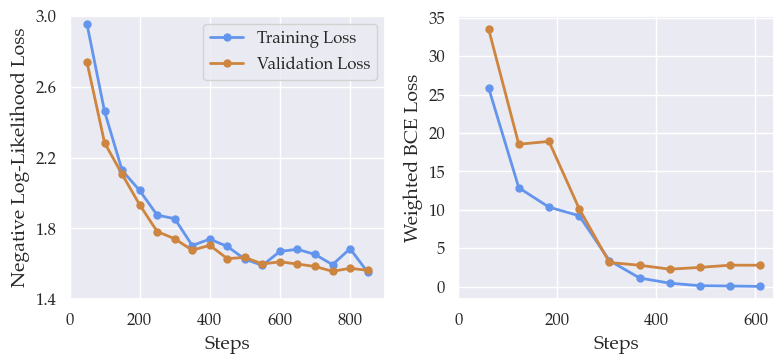

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

plt.rcParams.update({'axes.titlesize': 20, 'axes.labelsize': 14, 'xtick.labelsize' : 12, 'ytick.labelsize' : 12, 'font.family': 'sans-serif', 'font.sans-serif': ['Palatino'], 'legend.fontsize': 12})

fig, ax = plt.subplots(1, 2, figsize=(8, 3.8))

ax[0].plot(losses.index, losses,'o-', label='Training Loss', color='cornflowerblue', linewidth=2, markersize=5)
# ax[0].plot(losses_ma.index, losses_ma, label='Training Loss (MA)', color='blue')
ax[0].plot(val_losses.index, val_losses,'o-', label='Validation Loss', color='peru', linewidth=2, markersize=5)
# ax[0].plot(val_losses_ma.index, val_losses_ma, label='Validation Loss (MA)', color='orange')
# ax[0].set_title('Text Generation Loss Over Steps')
ax[0].set_xlim(0, 900)
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('Negative Log-Likelihood Loss')
ax[0].set_yticks([1.4, 1.8, 2.2, 2.6, 3.0])
ax[0].set_ylim(1.4, 3.0)
ax[0].legend()

ax[1].plot(tc_a_train_df['step'], tc_a_train_df['loss'], 'o-', label='Training Loss', color='cornflowerblue', linewidth=2, markersize=5)
ax[1].plot(tc_a_eval_df['step'], tc_a_eval_df['eval_loss'],'o-', label='Validation Loss', color='peru', linewidth=2, markersize=5)
# ax[1].set_title('Text Classification Loss Over Steps')
ax[1].set_xlim(0, None)
ax[1].set_xlabel('Steps')
ax[1].set_ylabel('Weighted BCE Loss')
#ax[1].set_yticks([1, 2, 3, 4, 5])
ax[1].set_ylim(None, None)
#ax[1].legend(loc='upper left')

plt.tight_layout()
plt.savefig('training_analysis.svg', dpi=300, bbox_inches='tight')
plt.show()